In [1]:
import at
import at.plot
import sys
if sys.version_info.minor < 9:
    from importlib_resources import files, as_file
else:
    from importlib.resources import files, as_file

In [2]:
from at.future import Variable, VariableList, ElementVariable, match
from at import LocalOpticsObservable, ObservableList

# Correlated variables

In this example of correlation between variables, we vary the length of the two drifts
surrounding a monitor but keep the sum of their lengths constant.

Using these 2 correlated variables, we will match a constraint on the monitor.

## Load a test lattice

In [3]:
fname = 'hmba.mat'
with as_file(files('machine_data') / fname) as path:
    hmba_lattice = at.load_lattice(path)

Isolate the two drifts

In [4]:
dr1 = hmba_lattice["DR_01"][0]
dr2 = hmba_lattice["DR_02"][0]

Get the total length to be preserved

In [5]:
l1 = dr1.Length
l2 = dr2.Length
ltot = l1 + l2

Create a constraint {math}`\beta_y=3.0` on `BPM_01`

In [6]:
obs1 = LocalOpticsObservable('BPM_01', 'beta', plane='v', target=3.0)

## Method 1: using parameters

We parametrise the lengths of the drifts surrounding the monitor

### Parametrise the two drifts:

In [7]:
param1 = dr1.parametrise('Length')
dr2.Length = ltot-param1

### Run the matching

In [8]:
variables = VariableList([param1])
constraints = ObservableList(hmba_lattice, [obs1])
match(hmba_lattice, variables, constraints, verbose=1)


1 constraints, 1 variables, using method lm

`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 2.6515e+00, final cost 9.8608e-32, first-order optimality 3.26e-16.

Constraints:

location              Initial            Actual         Low bound        High bound          residual 
beta[y]
    BPM_01                5.30283               3.0               3.0               3.0       1.97062e-11 

Variables:

        Name      Initial          Final        Variation

      param1    2.651400e+00    9.693839e-01   -1.682016e+00


### Show the modified lattice

In [9]:
for elem in hmba_lattice.select([2,3,4]):
    print(elem)

Drift:
	FamName : DR_01
	Length : Param(0.9693838658136734, name='param1')
	PassMethod : DriftPass
Monitor:
	FamName : BPM_01
	Length : 0.0
	PassMethod : IdentityPass
	Offset : [0 0]
	Scale : [1 1]
	Reading : [0 0]
	Rotation : [0 0]
Drift:
	FamName : DR_02
	Length : ParamBase(1.7245681341863266, name='calc1')
	PassMethod : DriftPass


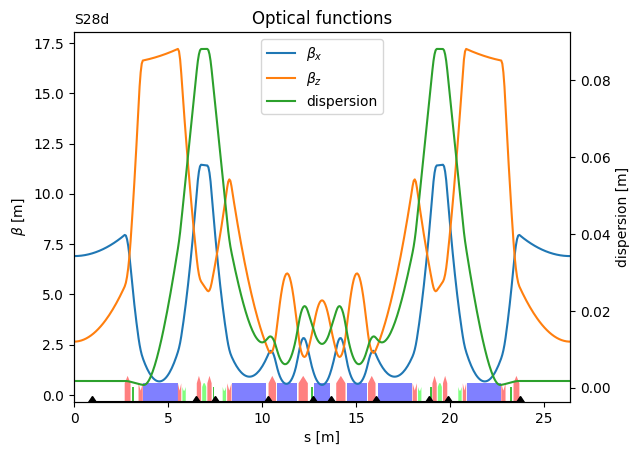

(<Axes: title={'left': 'S28d', 'center': 'Optical functions'}, xlabel='s [m]', ylabel='$\\beta$ [m]'>,
 <Axes: ylabel='dispersion [m]'>,
 <Axes: >)

In [10]:
hmba_lattice.plot_beta()

The first BPM is moved to a location where {math}`\beta_y=3.0`

Restore the lattice

In [11]:
dr1.Length = l1
dr2.Length = l2

## Method 2: custom variable

We define a new variable class which will act on the two elements and fulfil the constraint

### Define a variable coupling two drift lengths so that their sum is constant:

In [12]:
class ElementShifter(Variable):
    def __init__(self, dr1, dr2, total_length=None, **kwargs):
        """Varies the length of the elements *dr1* and *dr2*
        keeping the sum of their lengths equal to *total_length*.

        If *total_length* is None, it is set to the initial total length
        """        
        # store indexes of the 2 variable elements
        self.dr1 = dr1
        self.dr2 = dr2
        # store the initial total length
        if total_length is None:
            total_length = dr1.Length + dr2.Length
        self.length = total_length
        super().__init__(bounds=(0.0, total_length), **kwargs)

    def _setfun(self, value, ring=None):
        dr1.Length = value
        dr2.Length = self.length - value

    def _getfun(self, ring=None):
        return  dr1.Length

Create a variable moving the monitor `BPM_01`

In [13]:
var0 = ElementShifter(dr1, dr2, name='DR_01', total_length=ltot)

### Run the matching

In [14]:
variables = VariableList([var0])
constraints = ObservableList(hmba_lattice, [obs1])
match(hmba_lattice, variables, constraints, verbose=1)


1 constraints, 1 variables, using method trf

`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 2.6515e+00, final cost 7.1885e-27, first-order optimality 8.52e-14.

Constraints:

location              Initial            Actual         Low bound        High bound          residual 
beta[y]
    BPM_01                5.30283               3.0               3.0               3.0       1.19332e-16 

Variables:

        Name      Initial          Final        Variation

       DR_01    2.651400e+00    9.693778e-01   -1.682022e+00


### Show the modified lattice

In [15]:
for elem in hmba_lattice.select([2,3,4]):
    print(elem)

Drift:
	FamName : DR_01
	Length : 0.9693778252605573
	PassMethod : DriftPass
Monitor:
	FamName : BPM_01
	Length : 0.0
	PassMethod : IdentityPass
	Offset : [0 0]
	Scale : [1 1]
	Reading : [0 0]
	Rotation : [0 0]
Drift:
	FamName : DR_02
	Length : 1.7245741747394425
	PassMethod : DriftPass


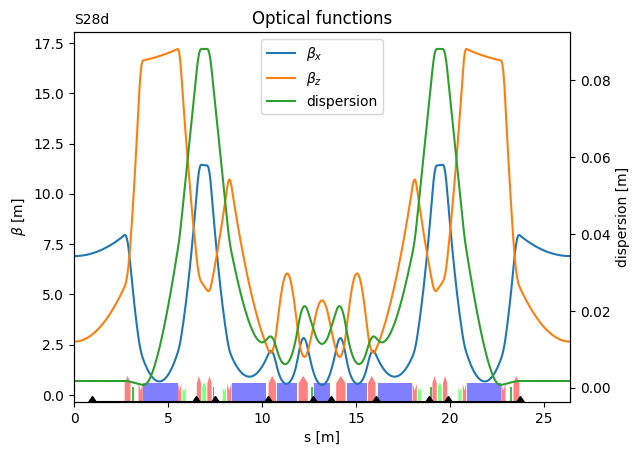

(<Axes: title={'left': 'S28d', 'center': 'Optical functions'}, xlabel='s [m]', ylabel='$\\beta$ [m]'>,
 <Axes: ylabel='dispersion [m]'>,
 <Axes: >)

In [16]:
hmba_lattice.plot_beta()